# Section 5.1.1: Regression with random neural networks

This page contains simulations in Section 5.1.1.

## Contents

    - Training and test performance of random weights neural networks
    - Double descent test curve

## Training and test performance of random weights neural networks

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
from tensorflow.keras.datasets import mnist,fashion_mnist
pi = np.pi

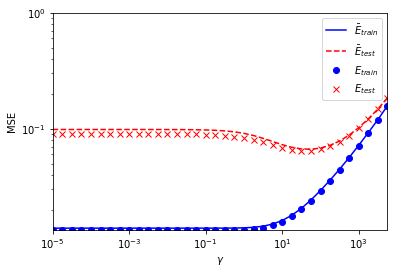

In [37]:
testcase='fashion'
sigma_fun = 'ReLU'  # among 'ReLU', 'sign', 'posit', 'erf', 'poly2', 'cos','sin','abs', 'exp'

n = 1024
n_test = 512
N = 512
cs = [1/2,1/2]
k = len(cs)

if testcase == 'MNIST':
    selected_labels=[7,9]
    (init_data, init_labels), _ = mnist.load_data()

if testcase == 'fashion':
    selected_labels=[1,2]
    (init_data, init_labels), _ = fashion_mnist.load_data()
    
idx_init_labels = np.argsort(np.array(init_labels))    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=(data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p)

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2),0))

for j in range(len(selected_labels)):
    selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

means = lambda l : np.mean(selected_data[l],axis=1)
covs  = lambda l : 1/np.shape(selected_data[l])[1]*(selected_data[l]@selected_data[l].T)-np.outer(means(l),means(l))


X=np.zeros( (p,n) )
X_test=np.zeros( (p,n_test) )

for i in range(k):
    data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
    X_test[:,int(np.sum(cs[:i])*n_test):int(np.sum(cs[:i+1])*n_test)]=data[:,n:n+int(n_test*cs[i])] 
    
y = np.concatenate([-np.ones(int(cs[0]*n)),np.ones(int(cs[1]*n))])
y_test = np.concatenate([-np.ones(int(cs[0]*n_test)),np.ones(int(cs[1]*n_test))])

if sigma_fun == 't':
    sig = lambda t : t
    K_xy = lambda x,y : x.T@y

if sigma_fun == 'poly2':
    poly2A = -1/2
    poly2B = 0
    poly2C = 1
    m4 = 3
    m3 = 0
    m2 = 1
    sig = lambda t : poly2A*t**2+poly2B*t+poly2C
    K_xy = lambda x,y : poly2A**2*(m2**2*(2*(x.T@y)**2+(x**2).T@np.ones( (np.size(x,0),np.size(x,0)) )@(y**2))+(m4-3*m2**2)*(x**2).T@(y**2)+poly2B**2*(m2*x.T@y))+poly2A*poly2B*m3*((x**2).T@y+x.T@(y**2))+poly2A*poly2C*m2*np.outer(np.diag(x.T@x),np.diag(y.T@y)) + poly2C**2

if sigma_fun == 'ReLU':
    sig = lambda t : np.maximum(t,0)
    angle_xy = lambda x,y : np.minimum(np.maximum(-1+1e-10,np.diag(1/np.sqrt(np.diag(x.T@x)))@(x.T@y)@np.diag(1/np.sqrt(np.diag(y.T@y)))),1-1e-10)
    K_xy = lambda x,y : np.outer(np.sqrt(np.diag(x.T@x)),np.sqrt(np.diag(y.T@y)))/(2*pi)*(angle_xy(x,y)*np.arccos(-angle_xy(x,y))+np.sqrt(1-angle_xy(x,y)**2))

if sigma_fun == 'sign':
    sig = lambda t : np.sign(t)
    K_xy = lambda x,y : 2/pi*np.arcsin(np.diag(1/np.sqrt(np.diag(x.T@x)))@(x.T@y)@np.diag(1/np.sqrt(np.diag(y.T@y))))

if sigma_fun == 'posit':
    sig = lambda t : (np.sign(t)+1)/2
    K_xy = lambda x,y : 1/2-1/(2*pi)*np.arccos(np.diag(1/np.sqrt(np.diag(x.T@x)))@(x.T@y)@np.diag(1/np.sqrt(np.diag(y.T@y))))

if sigma_fun == 'erf':
    sig = lambda t : scipy.special.erf(t)
    K_xy = lambda x,y : 2/pi*np.arcsin(np.diag(1/sqrt(1+2*np.diag(x.T@x)))@(2*x.T@y)@np.diag(1/np.sqrt(1+2*np.diag(y.T@y))))

if sigma_fun == 'cos':
    sig = lambda t : np.cos(t)
    K_xy = lambda x,y : np.diag(np.exp(-np.diag(x.T@x/2)))@np.cosh(x.T@y)@np.diag(np.exp(-np.diag(y.T@y/2)))

if sigma_fun == 'sin':
    sig = lambda t : np.sin(t)
    K_xy = lambda x,y : np.diag(np.exp(-np.diag(x.T@x/2)))@sinh(x.T@y)@np.diag(np.exp(-np.diag(y.T@y/2)))

if sigma_fun == 'abs':
    sig = lambda t : np.abs(t)
    angle_xy = lambda x,y : np.minimum(np.maximum(-1+1e-10,np.diag(1/np.sqrt(np.diag(x.T@x)))@(x.T@y)@np.diag(1/np.sqrt(np.diag(y.T@y)))),1-1e-10)
    K_xy = lambda x,y : np.outer(2*np.sqrt(np.diag(x.T@x)),np.sqrt(np.diag(y.T@y)))/pi*(angle_xy(x,y)*(np.arccos(-angle_xy(x,y))-pi/2)+np.sqrt(1-angle_xy(x,y)**2))

if sigma_fun == 'exp':
    sig = lambda t : np.exp(-t**2/2)
    K_xy = lambda x,y : 1/np.sqrt( 1 + (x**2).T@np.ones( (size(x,0),size(x,0)) )@(y**2) + np.diag(x.T@x).reshape( (size(x,0),1) ) + np.diag(y.T@y).reshape( (1,size(y,0)) ) - (x.T@y)**2)


K_X = np.real(K_xy(X,X))
eig_K_X,U_K_X=np.linalg.eig(K_X)
#U_K_X = real(U_K_X)

Up_K_X = U_K_X.T@K_X

U_K_y  = U_K_X.T@y

K_XXtest = np.real(K_xy(X,X_test))
U_K_XXtest = U_K_X.T@K_XXtest
D_U_K_XXtest_2 = np.diag(U_K_XXtest@U_K_XXtest.T)

K_Xtest = K_xy(X_test,X_test)
D_K_Xtest = np.real(np.diag(K_Xtest))


gammas=[10**y for y in np.arange(-5,4,.25)]

bar_E_train = np.zeros(len(gammas))
bar_E_test  = np.zeros(len(gammas))

delta = 0
for iter_gamma,gamma in enumerate(gammas):

    delta_tmp=1
    while np.abs(delta-delta_tmp)>1e-6:
        delta_tmp=delta
        delta = 1/n*np.sum(eig_K_X/(N/n*eig_K_X/(1+delta)+gamma))

    eig_bar_K = eig_K_X*(N/n/(1+delta))
    eig_bar_Q = 1/(eig_bar_K+gamma)

    bar_E_train[iter_gamma] = gamma**2*np.sum(np.abs(U_K_y)**2*eig_bar_Q**2*(1/N*np.sum(eig_bar_K*eig_bar_Q**2)/(1-1/N*np.sum(eig_bar_K**2*eig_bar_Q**2))*eig_bar_K+1))/n
    bar_E_test[iter_gamma] = 1/n_test*np.sum( (y_test - (N/n/(1+delta))*U_K_XXtest.T@(eig_bar_Q*U_K_y))**2 ) + 1/N*np.sum(np.abs(U_K_y)**2*(eig_bar_Q**2*eig_bar_K))/(1-1/N*np.sum(eig_bar_K**2*eig_bar_Q**2))*(1/n_test*(N/n/(1+delta))*np.sum(D_K_Xtest)-gamma/n_test*np.sum(eig_bar_Q**2*( (N/n/(1+delta))**2*D_U_K_XXtest_2 ))-1/n_test*np.sum(eig_bar_Q*( (N/n/(1+delta))**2*D_U_K_XXtest_2 )))
    
loops=30

E_train = np.zeros( (len(gammas),loops) )
E_test  = np.zeros( (len(gammas),loops) )

for loop in range(loops):

    W = np.random.randn(N,p)
    Sigma = sig(W@X)
    Sigma_test = sig(W@X_test)

    iter_gamma=1
    for iter_gamma,gamma in enumerate(gammas):

        inv_tQ_r = scipy.linalg.solve(Sigma.T@Sigma/n+gamma*np.eye(n),y)
        beta = Sigma/n@inv_tQ_r

        E_train[iter_gamma,loop]=np.linalg.norm(y-Sigma.T@beta)**2/n
        E_test[iter_gamma,loop]=np.linalg.norm(y_test-Sigma_test.T@beta)**2/n_test

plt.loglog(gammas,bar_E_train,'b',label=r'$\bar E_{train}$')
plt.loglog(gammas,bar_E_test,'r--',label=r'$\bar E_{test}$')
plt.loglog(gammas,np.mean(E_train,1),'ob',label=r'$E_{train}$')
plt.loglog(gammas,np.mean(E_test,1),'xr',label=r'$E_{test}$')
plt.xlabel(r'$\gamma$')
plt.ylabel('MSE')
plt.gca().set_xlim(np.min(gammas),np.max(gammas))
plt.gca().set_ylim(np.min(np.mean(E_train,1)),1)    
_ = plt.legend()

## Double descent test curve

Empirical versus theoretical training and test error as a function of $N/n$

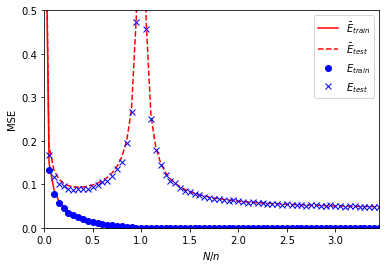

In [38]:
Ns = np.floor(n*np.arange(0,3.5,0.05)).astype(int)
gamma = 1e-7

bar_E_train = np.zeros(len(Ns))
bar_E_test  = np.zeros(len(Ns))

loops=30
E_train = np.zeros((len(Ns),loops))
E_test  = np.zeros((len(Ns),loops))

for iter_N,N in enumerate(Ns):

    delta = 0
    delta_tmp=1
    while np.abs(delta-delta_tmp)>1e-6:
        delta_tmp=delta
        delta = 1/n*np.sum(eig_K_X/(N/n*eig_K_X/(1+delta)+gamma))

    eig_bar_K = eig_K_X*(N/n/(1+delta))
    eig_bar_Q = 1/(eig_bar_K+gamma)

    if N==0:
        bar_E_train[iter_N] = 1
        bar_E_test[iter_N]  = 1
    else:
        bar_E_train[iter_N] = gamma**2*np.sum(np.abs(U_K_y)**2*eig_bar_Q**2*(1/N*np.sum(eig_bar_K*eig_bar_Q**2)/(1-1/N*np.sum(eig_bar_K**2*eig_bar_Q**2))*eig_bar_K+1))/n
        bar_E_test[iter_N] = 1/n_test*np.sum( (y_test - (N/n/(1+delta))*U_K_XXtest.T@(eig_bar_Q*U_K_y))**2 ) + 1/N*np.sum(np.abs(U_K_y)**2*(eig_bar_Q**2*eig_bar_K))/(1-1/N*np.sum(eig_bar_K**2*eig_bar_Q**2))*(1/n_test*(N/n/(1+delta))*np.sum(D_K_Xtest)-gamma/n_test*np.sum(eig_bar_Q**2*( (N/n/(1+delta))**2*D_U_K_XXtest_2 ))-1/n_test*np.sum(eig_bar_Q*( (N/n/(1+delta))**2*D_U_K_XXtest_2 )))

    for loop in range(loops):

        W = np.random.randn(N,p)

        Sigma = sig(W@X)
        Sigma_test = sig(W@X_test)

        inv_tQ_r = scipy.linalg.solve(Sigma.T@Sigma/n+gamma*np.eye(n),y)
        beta = Sigma/n@inv_tQ_r

        E_train[iter_N,loop]=np.linalg.norm(y-Sigma.T@beta)**2/n
        E_test[iter_N,loop]=np.linalg.norm(y_test-Sigma_test.T@beta)**2/n_test

plt.plot(Ns/n,bar_E_train,'r',label=r'$\bar E_{train}$')
plt.plot(Ns/n,bar_E_test,'--r',label=r'$\bar E_{test}$')
plt.plot(Ns/n,np.mean(E_train,1),'ob',label=r'$E_{train}$')
plt.plot(Ns/n,np.mean(E_test,1),'xb',label=r'$E_{test}$')
plt.xlabel(r'$N/n$')
plt.ylabel('MSE')
plt.gca().set_xlim([np.min(Ns/n),np.max(Ns/n)])
plt.gca().set_ylim([0,.5])
_ = plt.legend()